fem2dsimple
=============

`fem2dsimple` is a simple Python solver for the 2D Poisson equation using the finite element method (FEM).  The solution is computed over a rectangular mesh, with Dirichlet boundary conditions.

Minimal theory
--------------
The Poisson equation with Dirichlet boundary conditions is given by

\begin{align*}
\nabla^2 u(x,y) = f(x,y) \quad & \forall (x,y) \in \Omega := [0,L_x] \times [0,L_y], \\
u(x,y) = 0               \quad & \forall (x,y) \in \partial\Omega,
\end{align*}


where $f$ is the inhomogeneity and $u$ the unknown.  By means of partial integration and with the definition of a basis set $\{v_i\}$, the problem can be recast as a linear system,

$$
\sum_j A_{ij} u_j = b_i
$$

with $A_{ij} = \int_\Omega \nabla v_i(x,y) \nabla v_j(x,y) \mathrm d\sigma$, known as the *stiffness matrix*; and $b_i = \int_\Omega f(x,y) v_i(x,y) \mathrm d\sigma$.

`fem2dsimple` uses triangular elements to discretize the rectangular domain, and piece-wise linear polynomials as a basis set.  Each basis function $v_i$ is defined in the neighborhood of the $i$-th node and is constrained to have compact support: namely, it equals 1 on the $i$-th node and vanishes on the neighbouring nodes.

Minimal example
---------------
To solve the Poisson equation with `fem2dsimple`, you need to specify your problem first: namely, you need to define the inhomogeneity $f(x,y)$.  Begin by defining your function of interest:

In [28]:
import numpy as np

# define a 2D gaussian function, p = [(x0,y0), (x1,y0), ...]
def f(p):
    sigma_x = 0.01
    sigma_y = 0.01
    x0      = 0.5
    y0      = 0.5
    N       = 1.0
    return N * np.exp(-((p[...,0]-x0)**2/(2.0*sigma_x) +
                        (p[...,1]-y0)**2/(2.0*sigma_y)))

To solve the problem defined by this function, import the `fem2d` module and create a mesh:

In [29]:
import fem2d as fem

Nx = 100    # number of rectangular mesh subdivisions in x
Ny = 100    # number of rectangular mesh subdivisions in y
Lx = 1.0    # x length of mesh rectangle
Ly = 1.0    # y length of mesh rectangle

# N.B.: each rectangular subdivision contains two elements (right-angled
# triangles), like so:
#
#  _ _!____!_ _
#     |   /|
#     |  / |
#     | /  |
#  _ _|/___|_ _
#     !    !
#

mesh = fem.TriangularMesh2D(Nx, Ny, Lx, Ly)
mesh.nodes

array([[0.  , 0.  ],
       [0.01, 0.  ],
       [0.02, 0.  ],
       ...,
       [0.98, 1.  ],
       [0.99, 1.  ],
       [1.  , 1.  ]])

Generate the coefficients matrix $A$ (i.e. the stiffness matrix) and the constants vector $b$ of the linear system:

In [30]:
A_mat = fem.stiffn(mesh)
b_vec = fem.fv_int(mesh, f)

Since $A$ is a banded matrix, `fem2d.stiffn` by default returns a matrix in [diagonal ordered form](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html), as accepted by the `scipy.linalg.solve_banded` solver:

In [31]:
A_mat

matrix([[ 0. ,  0. ,  0. , ..., -1. , -1. , -0.5],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        ...,
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [-0.5, -1. , -1. , ...,  0. ,  0. ,  0. ]])

Before solving the system efficiently with the `scipy.linalg.solve_banded` solver,  you need to retrieve the numbers of non-zero upper and lower diagonals of $A$.  The two happen to coincide ($A$ is symmetric) and be equal to the number of nodes in a row of the mesh, which is stored in the `fem2d.TriangularMesh2D` type as `nx`:

In [32]:
nx = mesh.nx
nx

101

Now you're all set to fire up `scipy.linalg.solve_banded`:

In [33]:
from scipy.linalg import solve_banded
u = solve_banded((nx,nx), A_mat, b_vec)

And finally the solution can be plotted:

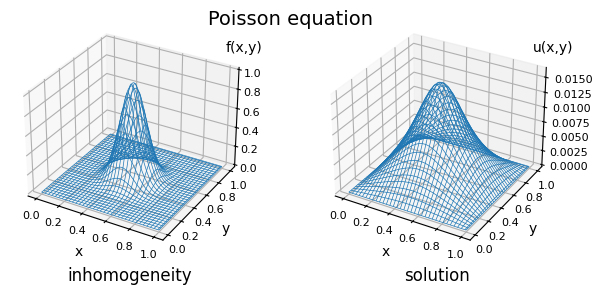

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

# prepare (x,y) grid
nx, ny, nodes = mesh.nx, mesh.ny, mesh.nodes
X = nodes[:,0].reshape(nx,ny)
Y = nodes[:,1].reshape(nx,ny)

fig = plt.figure(figsize=(6.4, 3.0))
fig.suptitle("Poisson equation", y= 0.95, fontsize=14)

# first subplot: f(x, y), inhomogeneity of the Poisson equation
Z = f(nodes).reshape(nx,ny)

ax = fig.add_axes((0.0, 0.13, 0.5, 0.8), projection='3d')
ax.set_title("inhomogeneity", y=-0.15)
ax.tick_params(labelsize=8, pad=-2)
ax.set_xlabel('x', labelpad=-4)
ax.set_ylabel('y', labelpad=-4)
ax.text2D(0.90, 0.85, "f(x,y)", transform=ax.transAxes)
ax.plot_wireframe(X, Y, Z, linewidths=0.5)

# second subplot: u, solution of the linear system
Z = u.reshape(nx,ny)

ax = fig.add_axes((0.48, 0.13, 0.5, 0.8), projection='3d')
ax.set_title("solution", y=-0.15)
ax.tick_params(labelsize=8, pad=-2)
ax.tick_params('z', pad=4)
ax.set_xlabel('x', labelpad=-4)
ax.set_ylabel('y', labelpad=-4)
ax.text2D(0.90, 0.85, "u(x,y)", transform=ax.transAxes)
ax.plot_wireframe(X, Y, Z, linewidths=0.5)

# plt.savefig("poisson.png")
plt.show()

In the long range, the solution of the Poisson equation with a gaussian inhomogeneity should resemble $\sim 1/r$, with $r=\sqrt{x^2+y^2}$: this goes to zero more slowly than a gaussian function (the latter decaying exponentially).  Here you can tell that $u(r)$ does indeed go to zero more slowly than $f(r)$.

Technical details
-----------------

Much of the challenge of implementing the FEM numerically is posed by the construction of the stiffness matrix.  `fem2dsimple` relies on `numpy` data structures and `scipy` functionalities to overcome said challenge.

The `stiffn` method of the `TriangularMesh2D` class is in charge of constructing the stiffness matrix.  It does so by making use of the `scipy.sparse.coo_matrix` utility for the creation of sparse matrices, which returns a matrix in the COO format upon providing three arrays: one containing all the non-vanishing elements (called `data` in the code), and two specifying the row and column indices where each element recored in `data` must be located in the final matrix (called `rows` and `columns` in the code).

The `scipy.sparse.coo_matrix` function allows for the conversion to the usual `numpy.array` format, provided that a shape is specified.  It is utilized by `stiffn` to return the stiffness matrix in two possible fashions: in its full $n \times n$ shape, with $n$ being the number of mesh nodes; or by packing it in the diagonal ordered form mentioned earlier.  The latter option requires remapping the indices stored in the `rows` and `columns` arrays as specified in the `scipy.linalg.solve_banded` documentation.

Working with the diagonal ordered form allows one to take full advantage of the banded nature of the stiffness matrix, which is ensured by the compact support of the basis functions, and their consequent limited overlap.  Following this route saves memory and computation time when solving the linear system:

In [35]:
from time import time

# general method
A_mat = fem.stiffn(mesh, return_bnd=False)
start = time(); u1 = np.linalg.solve(A_mat, b_vec); end = time();
print("\n          time to solution of np.linalg.solve : %5.3f s" % (end - start))

#smart method (take advantage of bandedness)
A_mat_bnd = fem.stiffn(mesh, return_bnd=True )
nx = mesh.nx
start = time(); u2 = solve_banded((nx,nx), A_mat_bnd, b_vec); end = time();
print(  "time to solution of scipy.linalg.solve_banded : %5.3f s" % (end - start))


          time to solution of np.linalg.solve : 16.314 s
time to solution of scipy.linalg.solve_banded : 0.054 s


Here we went two separate ways to solve the linear system: first we set the `return_bnd` argument of `stiffn`, and then we chose the appropriate solver: either the general `numpy.linalg.solve` solver when working with the full $n \times n$ matrix (general method), or `scipy.linalg.solve_banded` when working with the matrix in diagonal ordered form (smart method).  On my old desktop computer (Intel i3-4130) the general method took 16.314 seconds, while the smart one 0.054 seconds: it's a difference spanning three orders of magnitude!  And, of course, the two solutions must coincide:

In [37]:
if np.allclose(u1, u2, 1e-64, 1e-15):
    print("np.linalg.solve(A_mat, b_vec) yielded the same result as\n"
          "scipy.linalg.solve_banded(A_mat, b_vec), hooray!")
else:
    print("np.linalg.solve(A_mat, b_vec) did not yield the same result as\n"
          "scipy.linalg.solve_banded(A_mat, b_vec), alas!")

np.linalg.solve(A_mat, b_vec) yielded the same result as
scipy.linalg.solve_banded(A_mat, b_vec), hooray!


Further details concerning data layout, indexing and theoretical remarks can be found by inspecting the `fem2d.py` file and comments therein.  The `notebook` directory contains some examples showcasing the usage of the module.